# Affine Network with compliant Crosslinkers - Angular Integration

- Notebook for efficient UMAT analysis at the GP scale
- Includes fortran subroutines for random generation of material parameters

In [11]:
! /bin/python3.6 -m numpy.f2py -c -m umatpy py_anl_ai_mcs.f90 umat_anl_ai_mcs.f90

running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "umatpy" sources
f2py options: []
f2py:> /tmp/tmp6pchpi3q/src.linux-x86_64-3.6/umatpymodule.c
creating /tmp/tmp6pchpi3q/src.linux-x86_64-3.6
Reading fortran codes...
	Reading file 'py_anl_ai_mcs.f90' (format:free)
{'before': '', 'this': 'use', 'after': ',intrinsic :: iso_fortran_env '}
Line #3 in py_anl_ai_mcs.f90:"use,intrinsic :: ISO_Fortran_env "
	analyzeline: Could not crack the use statement.
	Reading file 'aba_param.inc' (format:fix)
Line #15 in py_anl_ai_mcs.f90:"PARAMETER(NTENS = 6, NSTATEV = NSDV, NSHR=3) "
	determineexprtype: could not determine expressions ('nsdv') type.
analyzeline: Failed to evaluate 'nsdv'. Ignoring: name 'nsdv' is not defined
	Reading file 'umat_anl_ai_mcs.f90' (format:free)
Line #19 in umat_a

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import product
from scipy.interpolate import interp1d
from sklearn.metrics import r2_score

import umatpy

In [13]:
base_dir = '/home/lpacheco/biopolymer-networks/3_affnet_cl_ai_mcs'
os.chdir(base_dir)

In [14]:
tex_fonts = {
    # Use LaTeX to write all text
    # "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}

# update to latex fonts
plt.rcParams.update(tex_fonts)

In [15]:
''' MATERIAL PROPERTIES '''

##### Penalty parameter (0) #####
K = 1000000000000.0 # 1000.0
##### Isotropic matrix (1-3) #####
C10 = 0.0 # 0.0
C01 = 0.0 # 0.0
PHI = 1.0 # Filament volume fraction 1.0
###### Single Filament (4-11) #####
L = 1.96 # Filament contour length [microm] 1.96
R0F = 1.63 # Filament initial end-to-end distance [microm] 1.63
R0C = 0.014 # CL initial end-to-end distance [microm] 0.014
ETA = 0.6666 # CL stiffness [0,1] 0.6666
MU0 = 11111111111111111111111138600.0 # Stretch modulus [pN] inf
BETA = 0.5 # 0.5
B0 = 294.0*16.0*1.38065e-5 # Bending stiffness (T*Lp*kb) [pN * microm**2] 294.0*16.0*1.38e-5
LAMBDA0 = 1.00 # Pre-stretch 1.00
##### Affine Network (12-13) #####
n = 7.66 # Isotropic filaments per unit volume [microm**-3] 7.66
B = 0.001 # Dispersion parameter 0.001

base_material_properties = [K,
    C10, C01, PHI,
    L, R0F, R0C, ETA, MU0, BETA, B0, LAMBDA0,
    n, B
]

mat_props_tex = ['$K$', '$C_{10}$', '$C_{01}$', '$\phi$', 
                 '$L$', '$r_{0,f}$', '$r_{0,c}$', '$\eta$', '$\mu_0$', '$\beta$', '$B_0$', '$\lambda_0$', 
                 '$n$', '$b$']

# Write material properties to a file
'''with open('material_properties.txt', 'w') as f:
    for prop in material_properties:
        f.write(f'{prop}\n')'''

"with open('material_properties.txt', 'w') as f:\n    for prop in material_properties:\n        f.write(f'{prop}\n')"

## Auxiliary Functions

In [16]:
''' AUX FUNCTIONS '''

# Setting the deformation gradient
def dfgrd(def_mode:str, stretch:float):
    """
    Computes the deformation gradient F for simple deformation modes.

    INPUTS: 
        def_mode: str - Deformation mode ('U' uniaxial, 'SS(x/y)' simple shear along x/y directions)
        stretch(/shear): float
    OUTPUTS: 
        F: ndarray - Deformation gradient (3x3)
    """
    if def_mode not in ['U', 'SSx', 'SSy']:
        raise ValueError("Invalid deformation mode. Choose 'U', 'SSx', or 'SSy'.")
    
    if not isinstance(stretch, (int, float)):
        raise TypeError("Stretch/shear value must be a number.")

    F = np.eye(3)
    
    if def_mode == 'U':
        F[0,0] = stretch
        F[1,1] = 1/np.sqrt(stretch)
        F[2,2] = 1/np.sqrt(stretch)
    elif def_mode == 'SSx':
        F[0,1] = stretch
    elif def_mode == 'SSy':
        F[1,0] = stretch
    return F

# Function for sensitivity analysis
def sens_analysis(def_mode:str,
                  stretch: list, 
                  time: list, 
                  mat_props: list, id_props:list, range_props:dict, 
                  id_stress:int):
    ''' Performs a sensitivity analysis on the chosen parameters for the compliant CL actin network (material point).

    INPUTS: def_mode - deformation mode ('U' uniaxial, 'SS(x/y)' simple shear along x/y directions);
            stretch - [stretch_min, stretch_max, nsteps];
            time - [time_0, time_end, dtime];
            mat_props - list with the baseline material properties;
            id_props - indices of the material properties being studies in the array mat_props [i,j,k, ...];
            range_props - dict{'min':[imin, jmin, kmin...], 'max':[imax, jmax, kmax...], 'nstep':[int, int, int, ...]};
            id_stress - index of the target stress component [xx yy zz xy xz yz];

    OUTPUTS: stress - stress array as a function of given stretch values (i_n, j_n, k_n..., nsteps);
             map_props - array that maps each stress vector to the corresponding material properties being studied (i_n, j_n, k_n..., len(id_props))'''
    # List with all values for each property being studied
    sens_props, len_props, stress_flat = [], [], []
    stretch_arr = np.arange(stretch[0], stretch[1], (stretch[1]-stretch[0])/stretch[2])
    for i, _ in enumerate(id_props):
        aux_min = range_props['min'][i]
        aux_max = range_props['max'][i]
        aux_inc = range_props['nstep'][i]
        aux_list = np.linspace(aux_min, aux_max, aux_inc).tolist()
        len_props.append(len(aux_list))
        sens_props.append(aux_list)
    len_props.append(len(id_props))
    comb_props_flat = list(product(*sens_props))
    for i, comb in enumerate(comb_props_flat):
        kstep = 0
        aux_time, dtime = [time[0:2], time[2]]
        aux_stress = []
        for j, id in enumerate(id_props):
            mat_props[id] = comb[j]
        for k, stretch in enumerate(stretch_arr):
            kstep += k
            F = dfgrd(def_mode, stretch)
            stress = umatpy.run_umat_py(mat_props, F, aux_time, dtime, kstep)
            aux_time[0] += dtime
            aux_stress.append(stress[id_stress])
        stress_flat.append(aux_stress)
    map_props = np.array(comb_props_flat).reshape(len_props)
    aux_shape = len_props[:-1]
    aux_shape.append(len(stretch_arr))
    stress_curves = np.array(stress_flat).reshape(aux_shape)
    return map_props, stress_curves


## Stress-Stretch curves

### Null deformation

(-0.1, 1.0)

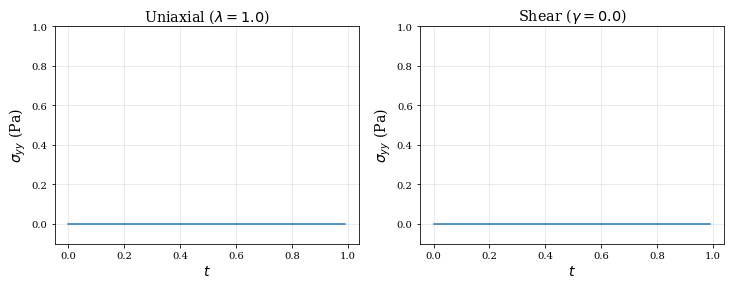

In [7]:
'UNIAXIAL and SHEAR'

material_properties = base_material_properties.copy()

stretch_initial = 1.0
stretch_max = 1.0
nsteps = 100
# dstretch = (stretch_max-stretch_initial)/nsteps
time_list = [0, 0]
time_initial = 0.0
time_max = 1.0
kstep=1
dtime = (time_max-time_initial)/nsteps
time_array = np.arange(time_initial, time_max, dtime)
stress_array_uni, stress_array_sh = np.zeros((1, nsteps)), np.zeros((1, nsteps))

kstep=1
stretch = 1.0
shear = 0.0
for j, t in enumerate(time_array):
    F_uni = dfgrd('U', stretch)
    F_sh = dfgrd('SSx', shear)
    stress_uni = umatpy.run_umat_py(material_properties, F_uni, [t, t+dtime], dtime, kstep)
    stress_array_uni[0,j] = stress_uni[0]
    stress_sh = umatpy.run_umat_py(material_properties, F_sh, [t, t+dtime], dtime, kstep)
    stress_array_sh[0,j] = stress_sh[1] - stress_sh[2]
    # time[0] += dtime
    kstep += 1

fig, axs = plt.subplots(1,2, figsize = (12,4))
axs[0].plot(time_array, stress_array_uni[0, :])
axs[0].set_title('Uniaxial ($\\lambda = 1.0$)')
axs[0].set_xlabel('$t$', fontsize=14)
axs[0].set_ylabel('$\\sigma_{yy}$ (Pa)', fontsize=14)
axs[0].grid(alpha=0.3)
axs[0].set_ylim((-0.1, 1))

axs[1].plot(time_array, stress_array_sh[0, :])
axs[1].set_title('Shear ($\\gamma = 0.0$)')
axs[1].set_xlabel('$t$', fontsize=14)
axs[1].set_ylabel('$\\sigma_{yy}$ (Pa)', fontsize=14)
axs[1].grid(alpha=0.3)
axs[1].set_ylim((-0.1, 1))

### Ramp deformation

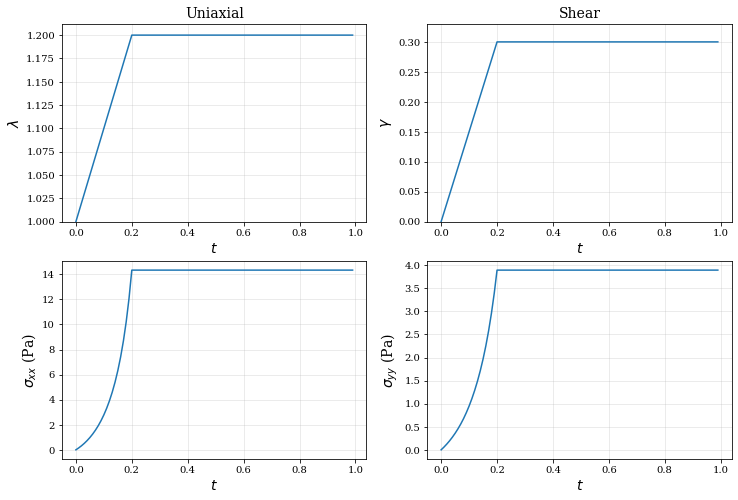

In [8]:
'UNIAXIAL and SHEAR'
stretch_list, shear_list = [], []
material_properties = base_material_properties.copy()

def ramp(time, ramp_time, min_def, max_def):
    # Initial time is zero!
    if time >= ramp_time:
        deformation = max_def
    if time < ramp_time:
        deformation = (max_def-min_def)/ramp_time * time + min_def
    return deformation 

stretch_initial = 1.0
stretch_max = 1.2
shear_initial = 0.0
shear_max = 0.3

nsteps = 100

time_list = [0, 0]
time_initial = 0.0
time_max = 1.0
ramp_time = 0.2
kstep=1
dtime = (time_max-time_initial)/nsteps

time_array = np.arange(time_initial, time_max, dtime)
stress_array_uni, stress_array_sh = np.zeros((1, nsteps)), np.zeros((1, nsteps))

kstep=1
for j, t in enumerate(time_array):
    stretch = ramp(t, ramp_time, stretch_initial, stretch_max)
    shear = ramp(t, ramp_time, shear_initial, shear_max)
    stretch_list.append(stretch)
    shear_list.append(shear)
    F_uni = dfgrd('U', stretch)
    F_sh = dfgrd('SSx', shear)
    stress_uni = umatpy.run_umat_py(material_properties, F_uni, [t, t+dtime], dtime, kstep)
    stress_array_uni[0,j] = stress_uni[0]
    stress_sh = umatpy.run_umat_py(material_properties, F_sh, [t, t+dtime], dtime, kstep)
    stress_array_sh[0,j] = stress_sh[1]-stress_sh[2]
    # time[0] += dtime
    kstep += 1

fig, axs = plt.subplots(2,2, figsize = (12,8))
axs[0,0].plot(time_array, stretch_list)
axs[0,0].set_xlabel('$t$', fontsize=14)
axs[0,0].set_ylabel('$\lambda$', fontsize=14)
axs[0,0].set_title('Uniaxial', fontsize=14)
axs[0,0].grid(alpha=0.3)
axs[0,0].set_ylim((1.,stretch_max*1.01))
axs[1,0].plot(time_array, stress_array_uni[0, :])
axs[1,0].set_xlabel('$t$', fontsize=14)
axs[1,0].set_ylabel('$\\sigma_{xx}$ (Pa)', fontsize=14)
axs[1,0].grid(alpha=0.3)

axs[0,1].plot(time_array, shear_list)
axs[0,1].set_xlabel('$t$', fontsize=14)
axs[0,1].set_ylabel('$\gamma$', fontsize=14)
axs[0,1].set_title('Shear', fontsize=14)
axs[0,1].grid(alpha=0.3)
axs[0,1].set_ylim((0,shear_max*1.1))
axs[1,1].plot(time_array, stress_array_sh[0, :])
axs[1,1].set_xlabel('$t$', fontsize=14)
axs[1,1].set_ylabel('$\\sigma_{yy}$ (Pa)', fontsize=14)
axs[1,1].grid(alpha=0.3)

# plt.savefig('1_02_08.pdf')


In [9]:
stress_array_uni[0, -20:], stress_array_sh[0, -20:]

(array([14.33866026, 14.33866026, 14.33866026, 14.33866026, 14.33866026,
        14.33866026, 14.33866026, 14.33866026, 14.33866026, 14.33866026,
        14.33866026, 14.33866026, 14.33866026, 14.33866026, 14.33866026,
        14.33866026, 14.33866026, 14.33866026, 14.33866026, 14.33866026]),
 array([3.8933659, 3.8933659, 3.8933659, 3.8933659, 3.8933659, 3.8933659,
        3.8933659, 3.8933659, 3.8933659, 3.8933659, 3.8933659, 3.8933659,
        3.8933659, 3.8933659, 3.8933659, 3.8933659, 3.8933659, 3.8933659,
        3.8933659, 3.8933659]))

### Linear deformation

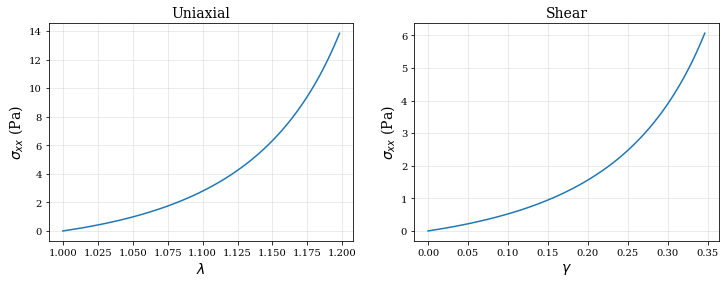

In [ ]:
'UNIAXIAL and SHEAR'
stretch_list, shear_list = [], []
material_properties = base_material_properties.copy()

stretch_initial = 1.0
stretch_max = 1.2
shear_initial = 0.0
shear_max = 0.35
nsteps = 100
dstretch = (stretch_max-stretch_initial)/nsteps
dshear = (shear_max-shear_initial)/nsteps

stress_array_uni, stress_array_sh = np.zeros((1, nsteps)), np.zeros((1, nsteps))
stretch_array = np.arange(stretch_initial, stretch_max, dstretch)
shear_array = np.arange(shear_initial, shear_max, dshear)

time = [0, 0]
dtime=0.1
kstep=1
for i, stretch in enumerate(stretch_array):
    F = dfgrd('U', stretch)
    stress_uni = umatpy.run_umat_py(material_properties, F, time, dtime, kstep)
    stress_array_uni[0,i] = stress_uni[0]
    time[0] += dtime
    kstep += 1

time = [0, 0]
kstep=1
for j, shear in enumerate(shear_array):
    F = dfgrd('SSx', shear)
    stress_sh = umatpy.run_umat_py(material_properties, F, time, dtime, kstep)
    stress_array_sh[0,j] = stress_sh[1] - stress_sh[2]
    time[0] += dtime
    kstep += 1


fig, axs = plt.subplots(1,2, figsize = (12,4))
axs[0].plot(stretch_array, stress_array_uni[0,:])
axs[0].set_xlabel('$\lambda$', fontsize=14)
axs[0].set_ylabel('$\\sigma_{xx}$ (Pa)', fontsize=14)
axs[0].set_title('Uniaxial', fontsize=14)
axs[0].grid(alpha=0.3)
axs[1].plot(shear_array, stress_array_sh[0, :])
axs[1].set_xlabel('$\gamma$', fontsize=14)
axs[1].set_ylabel('$\\sigma_{yy}$ (Pa)', fontsize=14)
axs[1].set_title('Shear', fontsize=14)
axs[1].grid(alpha=0.3)


## Sensitivity analysis

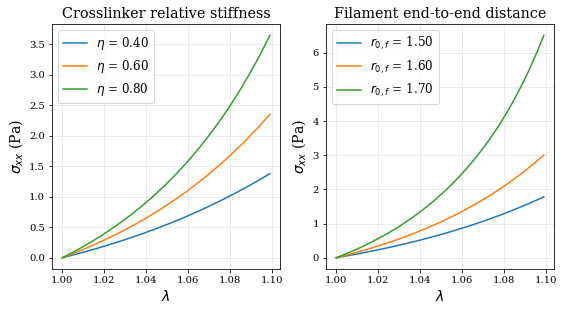

In [11]:
# Test if the sensitivity analysis function is working properly
material_properties = base_material_properties.copy()
'''range_dict = {'min':[1.96, 1.4, 0.01],
              'max':[2.16, 1.6, 0.014],
              'nstep':[3, 3, 3]}'''

# 1st plot data
range_dict = {'min':[0.4],
              'max':[0.8],
              'nstep':[3]}
map_array, curves = sens_analysis(def_mode='U', stretch=[1.0, 1.1, 100], time=[0,0,0.1], mat_props=material_properties, id_props=[7], range_props=range_dict, id_stress=0)
# print(map_array.shape, curves.shape)

# 2nd plot data
range_dict2 = {'min':[1.5],
              'max':[1.7],
              'nstep':[3]}
map_array2, curves2 = sens_analysis(def_mode='U', stretch=[1.0, 1.1, 100], time=[0,0,0.1], mat_props=material_properties, id_props=[5], range_props=range_dict2, id_stress=0)

# Sensitity analysis plots
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9,4.5))
for i in range(3):
    ax1.plot(np.arange(1.0, 1.1, (1.1-1.0)/100), curves[i,:], label=mat_props_tex[7] + f' = {map_array[i].item():.2f}')
    ax2.plot(np.arange(1.0, 1.1, (1.1-1.0)/100), curves2[i,:], label=mat_props_tex[5] + f' = {map_array2[i].item():.2f}')

ax1.set_xlabel('$\lambda$', fontsize=14)
ax1.set_ylabel('$\sigma_{xx}$ (Pa)', fontsize=14)
ax1.set_title('Crosslinker relative stiffness')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=12)

ax2.set_xlabel('$\lambda$', fontsize=14)
ax2.set_ylabel('$\sigma_{xx}$ (Pa)', fontsize=14)
ax2.set_title('Filament end-to-end distance')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=12)

# fig.savefig('00plot.png', bbox_inches='tight')

In [12]:
# Sensitivity analysis - Studying more than 1 parameter
material_properties = base_material_properties.copy()
stretch_aux_list = [1.0, 1.1, 100]
range_dict = {'min':[1.96, 1.4, 0.01],
              'max':[2.1, 1.6, 0.014],
              'nstep':[3, 3, 3]}

map_array, curves = sens_analysis(def_mode='U', stretch = stretch_aux_list, time=[0,0,0.1], mat_props=material_properties, id_props=[4,5,6], range_props=range_dict, id_stress=0)

Text(0, 0.5, '$\\sigma_{xx}$ (Pa)')

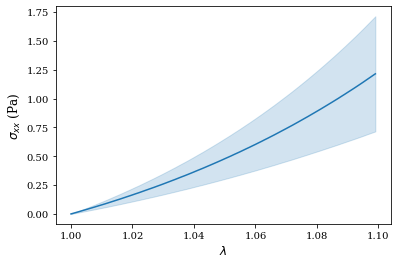

In [13]:
curves_for_df = curves.reshape(-1,100)
curve_id = np.arange(curves_for_df.shape[0])
stretches = np.tile(np.arange(stretch_aux_list[0], stretch_aux_list[1], (stretch_aux_list[1]-stretch_aux_list[0])/stretch_aux_list[2]), curves_for_df.shape[0])

df = pd.DataFrame({
    'curve_id': np.repeat(curve_id, 100),
    'stretch': stretches, 
    'stress': curves_for_df.flatten()
    })

plt.figure(figsize=(6,4))
sns.lineplot(x='stretch', y='stress', data=df, ci='sd')
plt.xlabel('$\lambda$')
plt.ylabel('$\sigma_{xx}$ (Pa)')

## Model Validation

Comparison with results from "An affine continuum mechanical model for cross-linked F-actin networks with compliant linker proteins" (Holzapfel, Unterberger and Ogden, 2014) and results obtained using a single unit cube element in Abaqus.

In [14]:
# Get abaqus results
'''os.chdir('test_in_abaqus')
abq_sh_033 = np.load('output_sh_033.npy')
abq_sh_067 = np.load('output_sh_067.npy')
abq_sh_100 = np.load('output_sh_100.npy')
abq_list = [abq_sh_100, abq_sh_067, abq_sh_033]
os.chdir('..')'''

"os.chdir('test_in_abaqus')\nabq_sh_033 = np.load('output_sh_033.npy')\nabq_sh_067 = np.load('output_sh_067.npy')\nabq_sh_100 = np.load('output_sh_100.npy')\nabq_list = [abq_sh_100, abq_sh_067, abq_sh_033]\nos.chdir('..')"

In [15]:
'''##### Normal stress vs Shear deformation (Figure 6a) #####
material_properties = base_material_properties.copy()

# Shear
shear_initial = 0
shear_max = 0.35
nsteps = 100
dshear = (shear_max-shear_initial)/nsteps
# shear_array = np.arange(shear_initial, shear_max, dshear)
shear_array = np.linspace(shear_initial, shear_max, nsteps)
dtime = 0.01
# CL stiffness
etac_array = np.array([1, 2/3, 1/3])
# Stress
stress_array = np.zeros((len(etac_array), nsteps))
interp_list, r2_list = [], []

for i, etac in enumerate(etac_array):
    material_properties[7] = etac
    time = [0,0]
    for j, shear in enumerate(shear_array):
        kstep = j + 1
        F = dfgrd('SSx', shear)
        stress = umatpy.run_umat_py(material_properties, F, time, dtime, kstep)
        stress_array[i,j] = stress[1]-stress[2]
        time[0] += dtime

plt.figure(figsize=(6,5))
plt_colors = ['red', 'blue', 'green']

files_6a = sorted([file for file in os.listdir('Holzapfel2014_plots') if '6a' in file], reverse=True)
os.chdir('Holzapfel2014_plots')
for j, file in enumerate(files_6a):
    df = pd.read_csv(file, header=None, names=['x', 'y'])
    eta = etac_array[j]
    int_fun = interp1d(shear_array, stress_array[j,:], kind=5)
    stress_interp = int_fun([val for val in df['x'] if val < (shear_max - dshear)])
    r2 = r2_score(df['y'][:len(stress_interp)], stress_interp)
    r2_list.append(r2)
    plt.plot(df['x'], df['y'], color=plt_colors[j], linestyle='--')

for i, eta in enumerate(etac_array):
    r2 = r2_list[i]
    plt.plot(shear_array, stress_array[i,:], label=f'$\eta = $ {eta:.2f}' + f', $R^2=${r2:.3f}', color=plt_colors[i])'''

## Abaqus
'''for i, output in enumerate(abq_list):
    x = np.arctan(output[0,:])
    y = output[4,:]
    plt.plot(x, y, color=plt_colors[i], linestyle='dotted')'''
##

'''df2 = pd.read_csv('holz2014_4a_095.csv', header=None, names=['x', 'y'])
# plt.plot(df2['x'], df2['y'], color='orange', linestyle='-.', alpha=1.)
# df3 = pd.read_csv('holz2014_4b_095.csv', header=None, names=['x', 'y'])
# plt.plot(df3['x'], df3['y'], color='grey', linestyle='-.', alpha=1.)
os.chdir('..')
dashed_line = plt.plot([], [], color='black', linestyle='--', label='Holzapfel 2014')
# dotted_line = plt.plot([], [], color='black', linestyle='dotted', label='Abaqus (unit cube)')
# dashdot_line = plt.plot([], [], color='orange', linestyle='-.', label='Holzapfel 2014 (w/o CLs)')
plt.legend()
plt.grid(alpha=0.3)
plt.ylim((0,20))
plt.xlabel('Amount of shear $\gamma$ (-)', fontsize=14)
plt.ylabel('$\sigma_{yy}$ (Pa)', fontsize=14)
# plt.savefig('./figures/fig1.pdf', bbox_inches='tight')'''

"df2 = pd.read_csv('holz2014_4a_095.csv', header=None, names=['x', 'y'])\n# plt.plot(df2['x'], df2['y'], color='orange', linestyle='-.', alpha=1.)\n# df3 = pd.read_csv('holz2014_4b_095.csv', header=None, names=['x', 'y'])\n# plt.plot(df3['x'], df3['y'], color='grey', linestyle='-.', alpha=1.)\nos.chdir('..')\ndashed_line = plt.plot([], [], color='black', linestyle='--', label='Holzapfel 2014')\n# dotted_line = plt.plot([], [], color='black', linestyle='dotted', label='Abaqus (unit cube)')\n# dashdot_line = plt.plot([], [], color='orange', linestyle='-.', label='Holzapfel 2014 (w/o CLs)')\nplt.legend()\nplt.grid(alpha=0.3)\nplt.ylim((0,20))\nplt.xlabel('Amount of shear $\\gamma$ (-)', fontsize=14)\nplt.ylabel('$\\sigma_{yy}$ (Pa)', fontsize=14)\n# plt.savefig('./figures/fig1.pdf', bbox_inches='tight')"

In [16]:
'''##### Shear stress vs Shear deformation (Figure 6b) #####
material_properties = base_material_properties.copy()
# material_properties[6] = 0
# Shear
shear_initial = 0
shear_max = 0.35
nsteps = 100
dshear = (shear_max-shear_initial)/nsteps
shear_array = np.arange(shear_initial, shear_max, dshear)
dtime = 0.0001
# CL stiffness
etac_array = np.array([1, 2/3, 1/3])
# Stress
stress_array = np.zeros((len(etac_array), nsteps))
interp_list, r2_list = [], []

for i, etac in enumerate(etac_array):
    material_properties[7] = etac
    time = [0,0]
    for j, shear in enumerate(shear_array):
        kstep = j + 1
        F = dfgrd('SSx', shear)
        stress = umatpy.run_umat_py(material_properties, F, time, dtime, kstep)
        stress_array[i,j] = stress[3]
        time[0] += dtime

plt.figure(figsize=(6,5))
plt_colors = ['red', 'blue', 'green']

files_6b = sorted([file for file in os.listdir('Holzapfel2014_plots') if '6b' in file], reverse=True)
os.chdir('Holzapfel2014_plots')
for j, file in enumerate(files_6b):
    df = pd.read_csv(file, header=None, names=['x', 'y'])
    eta = etac_array[j]
    int_fun = interp1d(shear_array, stress_array[j,:], kind=5)
    stress_interp = int_fun([val for val in df['x'] if val < (shear_max - dshear)])
    r2 = r2_score(df['y'][:len(stress_interp)], stress_interp)
    r2_list.append(r2)
    plt.plot(df['x'], df['y'], color=plt_colors[j], linestyle='--')

for i, eta in enumerate(etac_array):
    r2 = r2_list[i]
    plt.plot(shear_array, stress_array[i,:], label=f'$\eta = $ {eta:.2f}' + f', $R^2=${r2:.3f}', color=plt_colors[i])'''

## Abaqus
'''for i, output in enumerate(abq_list):
    x = np.arctan(output[0,:])
    y = output[5,:]
    plt.plot(x, y, color=plt_colors[i], linestyle='dotted')'''
##

'''df2 = pd.read_csv('holz2014_4b_095.csv', header=None, names=['x', 'y'])
# plt.plot(df2['x'], df2['y'], color='orange', linestyle='-.', alpha=1.)
os.chdir('..')
dashed_line = plt.plot([], [], color='black', linestyle='--', label='Holzapfel 2014')
# dotted_line = plt.plot([], [], color='black', linestyle='dotted', label='Abaqus (unit cube)')
# dashdot_line = plt.plot([], [], color='orange', linestyle='-.', label='Holzapfel 2014 (w/o CLs)')
plt.legend()
plt.grid(alpha=0.3)
plt.ylim((0,20))
plt.xlabel('Amount of shear $\gamma$ (-)', fontsize=14)
plt.ylabel('$\\tau_{xy}$ (Pa)', fontsize=14)
# plt.savefig('./figures/fig3.pdf', bbox_inches='tight')'''

"df2 = pd.read_csv('holz2014_4b_095.csv', header=None, names=['x', 'y'])\n# plt.plot(df2['x'], df2['y'], color='orange', linestyle='-.', alpha=1.)\nos.chdir('..')\ndashed_line = plt.plot([], [], color='black', linestyle='--', label='Holzapfel 2014')\n# dotted_line = plt.plot([], [], color='black', linestyle='dotted', label='Abaqus (unit cube)')\n# dashdot_line = plt.plot([], [], color='orange', linestyle='-.', label='Holzapfel 2014 (w/o CLs)')\nplt.legend()\nplt.grid(alpha=0.3)\nplt.ylim((0,20))\nplt.xlabel('Amount of shear $\\gamma$ (-)', fontsize=14)\nplt.ylabel('$\\tau_{xy}$ (Pa)', fontsize=14)\n# plt.savefig('./figures/fig3.pdf', bbox_inches='tight')"

## Studying different contributions (AN and IM)

- Study the contribution of the Affine Network (AN), Non-affine Network (NA - not implemented) and Isotropic Ground-Substance/Matrix (IM)
- AN is only considered when the density of contractile bundles/isotropic filaments $n$>0.
- IM is only considered when the filament volume fraction $\varphi$<1.

In [17]:
# Common variables
stretch_array = np.linspace(1., 1.2, 200)
shear_array = np.linspace(0., 0.35, 200)
time = [0, 0]
dtime = 0.1

##### AN contribution #####
material_properties_AN = base_material_properties.copy()
stress_AN_uni, stress_AN_shear = [], [] 

for i, stretch in enumerate(stretch_array):
    kstep = i + 1
    F = dfgrd('U', stretch)
    stress = umatpy.run_umat_py(material_properties_AN, F, time, dtime, kstep)
    stress_AN_uni.append(stress[0])
    time[0] = (i+1)*dtime

for j, shear in enumerate(shear_array):
    kstep = j + 1
    F = dfgrd('SSx', shear)
    stress = umatpy.run_umat_py(material_properties_AN, F, time, dtime, kstep)
    stress_AN_shear.append(stress[3])
    time[0] = (j+1)*dtime

stress_AN_uni = np.array(stress_AN_uni)
stress_AN_shear = np.array(stress_AN_shear)

print(stress_AN_uni.shape, stress_AN_shear.shape)

(200,) (200,)


In [18]:
# IM contribution
material_properties_IM = base_material_properties.copy()
material_properties_IM[1:4] = [3.5, 2, 0.5]
material_properties_IM[12] = 0
stress_IM_uni, stress_IM_shear = [], [] 

for i, stretch in enumerate(stretch_array):
    kstep = i + 1
    F = dfgrd('U', stretch)
    stress = umatpy.run_umat_py(material_properties_IM, F, time, dtime, kstep)
    stress_IM_uni.append(stress[0])
    time[0] = (i+1)*dtime

for j, shear in enumerate(shear_array):
    kstep = j + 1
    F = dfgrd('SSx', shear)
    stress = umatpy.run_umat_py(material_properties_IM, F, time, dtime, kstep)
    stress_IM_shear.append(stress[3])
    time[0] = (j+1)*dtime

stress_IM_uni = np.array(stress_IM_uni)
stress_IM_shear = np.array(stress_IM_shear)

print(stress_IM_uni.shape, stress_IM_shear.shape)

(200,) (200,)


In [19]:
# Sum of separate/isolated contributions
stress_sum_uni = stress_AN_uni + stress_IM_uni
stress_sum_shear = stress_AN_shear + stress_IM_shear

# Running the UMAT considering both AN and IM contributions
material_properties = base_material_properties.copy()
material_properties[1:4] = [3.5, 2, 0.5]
stress_uni, stress_shear = [], [] 

for i, stretch in enumerate(stretch_array):
    kstep = i + 1
    F = dfgrd('U', stretch)
    stress = umatpy.run_umat_py(material_properties, F, time, dtime, kstep)
    stress_uni.append(stress[0])
    time[0] = (i+1)*dtime

for j, shear in enumerate(shear_array):
    kstep = j + 1
    F = dfgrd('SSx', shear)
    stress = umatpy.run_umat_py(material_properties, F, time, dtime, kstep)
    stress_shear.append(stress[3])
    time[0] = (j+1)*dtime

stress_uni = np.array(stress_uni)
stress_shear = np.array(stress_shear)

print(stress_uni.shape, stress_shear.shape)

(200,) (200,)


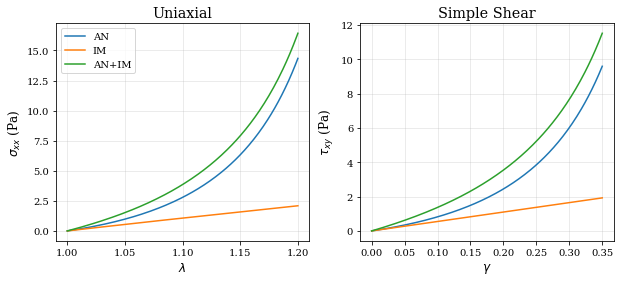

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(stretch_array, stress_AN_uni, label = 'AN')
axs[0].plot(stretch_array, stress_IM_uni, label = 'IM')
axs[0].plot(stretch_array, stress_uni, label = 'AN+IM')
axs[0].set_xlabel('$\lambda$')
axs[0].set_ylabel('$\sigma_{xx}$ (Pa)')
axs[0].set_title('Uniaxial')
axs[0].legend()

axs[1].plot(shear_array, stress_AN_shear, label = 'AN')
axs[1].plot(shear_array, stress_IM_shear, label = 'IM')
axs[1].plot(shear_array, stress_shear, label = 'AN+IM')
axs[1].set_xlabel('$\gamma$')
axs[1].set_ylabel('$\\tau_{xy}$ (Pa)')
axs[1].set_title('Simple Shear')

for ax in axs:
    ax.grid(True, alpha=0.3)

In [21]:
print(np.all(stress_sum_uni - stress_uni <= abs(1e-3)))
print(np.all(stress_sum_shear - stress_shear <= abs(1e-14)))

True
True


In [22]:
stress_sum_uni[:20], stress_uni[:20], len(stress_sum_uni), len(stress_uni)

(array([8.88178420e-16, 2.59141820e-02, 5.11087418e-02, 7.69222793e-02,
        1.02908805e-01, 1.28628651e-01, 1.55415492e-01, 1.81494618e-01,
        2.08645460e-01, 2.35539171e-01, 2.63062803e-01, 2.89889257e-01,
        3.17351911e-01, 3.45010261e-01, 3.72865300e-01, 4.01362817e-01,
        4.28731541e-01, 4.57637451e-01, 4.86306709e-01, 5.15182367e-01]),
 array([8.88178420e-16, 2.56921374e-02, 5.11087418e-02, 7.69222793e-02,
        1.02908805e-01, 1.28850695e-01, 1.55415492e-01, 1.81716663e-01,
        2.08645460e-01, 2.35539171e-01, 2.62840758e-01, 2.89889257e-01,
        3.17351911e-01, 3.45010261e-01, 3.72865300e-01, 4.01140772e-01,
        4.28953585e-01, 4.57637451e-01, 4.86306709e-01, 5.15182367e-01]),
 200,
 200)

## Comparison with Unterberger 2013

A new approach to model cross-linked actin networks: Multi-scale continuum formulation and computational analysis

In [1]:
data = {
    'R1_10_sxy': {
        'x': [0.1953580901856764, 0.19045092838196287, 0.18647214854111407, 0.18143236074270558, 0.1753315649867374, 0.17135278514588861, 0.16525198938992042, 0.16127320954907162, 0.15477453580901857, 0.1497347480106101, 0.14628647214854112, 0.14098143236074273, 0.13594164456233424, 0.13129973474801063, 0.12625994694960213, 0.12108753315649869, 0.11591511936339524, 0.11100795755968171, 0.10610079575596817, 0.10092838196286473, 0.09588859416445623, 0.09084880636604775, 0.08541114058355438, 0.08023872679045094, 0.07559681697612733, 0.07029177718832891, 0.06551724137931034, 0.0610079575596817, 0.05583554376657825, 0.05106100795755968, 0.046419098143236075, 0.04177718832891247, 0.0370026525198939, 0.03222811671087533, 0.02745358090185676, 0.022546419098143228, 0.01790450928381962, 0.013129973474801063, 0.007824933687002641, 0.0027851458885941593],
        'y': [16.10810810810811, 15.27027027027027, 14.35135135135135, 13.54054054054054, 12.594594594594595, 11.837837837837839, 10.891891891891891, 10.162162162162161, 9.405405405405405, 8.513513513513514, 7.864864864864865, 7.162162162162161, 6.513513513513513, 5.837837837837838, 5.297297297297297, 4.648648648648648, 4.243243243243243, 3.7027027027027026, 3.216216216216216, 2.864864864864865, 2.5405405405405403, 2.1621621621621614, 1.864864864864865, 1.6756756756756754, 1.4594594594594597, 1.2972972972972965, 1.108108108108107, 0.9459459459459456, 0.8918918918918912, 0.7837837837837824, 0.7567567567567561, 0.621621621621621, 0.5135135135135123, 0.45945945945945965, 0.3783783783783772, 0.32432432432432456, 0.2972972972972965, 0.18918918918918948, 0.108108108108107, 0]
    },
    'R1_10_sxx': {
        'x': [0.0024739583333333454, 0.00794270833333334, 0.012500000000000011, 0.017968750000000006, 0.022656250000000003, 0.02747395833333334, 0.03229166666666668, 0.04153645833333334, 0.036979166666666674, 0.046354166666666675, 0.05104166666666667, 0.06054687500000001, 0.06523437500000001, 0.08567708333333333, 0.09544270833333333, 0.10078125, 0.11093750000000001, 0.105859375, 0.11601562500000001, 0.12083333333333333, 0.12604166666666666, 0.1359375, 0.13098958333333333, 0.14075520833333333, 0.14596354166666667, 0.15000000000000002, 0.1609375, 0.17109375, 0.16497395833333334, 0.15494791666666669, 0.17513020833333334, 0.18125000000000002, 0.18645833333333334, 0.19010416666666669, 0.19518229166666667],
        'y': [0.0185185185185186, 0.11728395061728403, -0.11111111111111116, 0.11111111111111116, -0.16049382716049365, 0.25308641975308643, 0.4506172839506173, 0.5, -0.04938271604938249, -0.8024691358024691, -0.9135802469135799, -0.3580246913580245, -0.5061728395061729, -0.4629629629629628, 0.6111111111111112, -0.2901234567901234, 0.154320987654321, 1.0246913580246915, 0.154320987654321, 0.7654320987654322, 0.8271604938271606, 0.7654320987654322, 2.4444444444444446, 2.253086419753086, 1.5925925925925926, 1.376543209876543, 1.2777777777777777, 1.3641975308641976, 2.240740740740741, 2.4814814814814814, 3.0617283950617282, 3.271604938271605, 3.3271604938271606, 3.7222222222222223, 3.45679012345679]
    },
    'R1_20_sxy': {
        'x': [0.0028960817717206128, 0.008347529812606475, 0.013117546848381595, 0.018228279386712093, 0.02333901192504259, 0.028449744463373075, 0.03321976149914821, 0.037819420783645655, 0.0424190800681431, 0.04718909710391823, 0.05178875638841567, 0.05672913117546848, 0.06201022146507666, 0.06643952299829642, 0.07137989778534923, 0.07597955706984669, 0.08057921635434412, 0.0858603066439523, 0.09063032367972743, 0.09522998296422487, 0.1, 0.10494037478705281, 0.11005110732538331, 0.11499148211243612, 0.12010221465076662, 0.12504258943781943, 0.12998296422487224, 0.13560477001703578, 0.14003407155025555, 0.14497444633730835, 0.15008517887563885, 0.15502555366269166, 0.16013628620102216, 0.16524701873935266, 0.17001703577512778, 0.17461669505962524, 0.17938671209540036, 0.1850085178875639, 0.18960817717206135, 0.19437819420783647, 0.19965928449744463, 0.20477001703577513, 0.20988074957410563, 0.21482112436115847, 0.22010221465076663, 0.2245315161839864, 0.22981260647359456, 0.2345826235093697, 0.2396933560477002, 0.244633730834753, 0.2497444633730835],
        'y': [0.08333333333333393, 0.06944444444444464, 0.13888888888888928, 0.125, 0.18055555555555625, 0.22222222222222232, 0.2777777777777777, 0.3333333333333339, 0.3333333333333339, 0.3888888888888893, 0.4027777777777777, 0.4583333333333339, 0.5277777777777777, 0.5694444444444446, 0.6388888888888893, 0.6805555555555554, 0.7361111111111116, 0.8055555555555554, 0.9027777777777777, 0.9583333333333339, 1.041666666666667, 1.1111111111111112, 1.2638888888888893, 1.3611111111111112, 1.541666666666667, 1.6527777777777781, 1.8333333333333335, 2.013888888888889, 2.25, 2.430555555555556, 2.666666666666667, 2.9027777777777777, 3.1527777777777777, 3.4583333333333335, 3.75, 4.041666666666667, 4.347222222222222, 4.708333333333333, 5.055555555555555, 5.402777777777778, 5.736111111111111, 6.180555555555555, 6.513888888888889, 6.916666666666666, 7.333333333333333, 7.722222222222221, 8.152777777777779, 8.61111111111111, 9.069444444444445, 9.541666666666666, 10.01388888888889]
    },
    'R1_20_sxx': {
        'x': [0.002828618968386029, 0.008319467554076546, 0.013144758735440937, 0.018469217970049925, 0.02312811980033279, 0.028119800332778708, 0.03261231281198004, 0.03760399334442596, 0.04242928452579035, 0.04708818635607322, 0.0524126455906822, 0.056738768718802, 0.06206322795341099, 0.0663893510815308, 0.07138103161397671, 0.07587354409317804, 0.0810316139767055, 0.08569051580698836, 0.09018302828618968, 0.09534109816971714, 0.09983361064891848, 0.10465890183028287, 0.10998336106489186, 0.1151414309484193, 0.11930116472545757, 0.12512479201331114, 0.12995008319467555, 0.14009983361064893, 0.15008319467554077, 0.14442595673876873, 0.13527454242928452, 0.15474209650582363, 0.15956738768718803, 0.1647254575707155, 0.16955074875207987, 0.17537437603993344, 0.1793677204658902, 0.1848585690515807, 0.1896838602329451, 0.194675540765391, 0.19983361064891847, 0.20449251247920133, 0.2098169717138103, 0.21480865224625625, 0.21980033277870217, 0.22462562396006658, 0.2296173044925125, 0.23494176372712147, 0.23960066555740434, 0.2447587354409318, 0.24941763727121466],
        'y': [0.01538461538461533, 0.2153846153846155, -0.1076923076923082, 0.2769230769230768, -0.04615384615384599, 0.6307692307692303, -0.09230769230769287, -0.33846153846153904, -0.815384615384616, -0.33846153846153904, -0.3230769230769237, -0.49230769230769234, -0.2153846153846155, 0.3692307692307688, -0.7846153846153854, 0.16923076923076863, -0.2615384615384615, 0.12307692307692264, 0.8615384615384611, 0.4615384615384617, 0.953846153846154, 0.5846153846153843, 1.1230769230769226, 0.7999999999999998, 2.092307692307692, 2.123076923076923, 2.6615384615384614, 2.4307692307692306, 3.2, 3.3846153846153846, 3.0615384615384613, 4.107692307692307, 4.584615384615384, 5.2153846153846155, 5.723076923076923, 5.815384615384615, 5.415384615384616, 6.3076923076923075, 7, 7.338461538461539, 7.784615384615385, 7.861538461538462, 8.092307692307692, 7.984615384615385, 8.153846153846153, 8.676923076923078, 8.876923076923077, 9.96923076923077, 9.830769230769231, 10.123076923076923, 10.03076923076923]
    },
    'R1_40_sxy': {
        'x': [0.007918552036199095, 0.012443438914027147, 0.01764705882352942, 0.022850678733031676, 0.02760180995475113, 0.032579185520362, 0.03687782805429865, 0.041855203619909506, 0.04660633484162896, 0.051809954751131225, 0.05633484162895928, 0.06153846153846154, 0.06583710407239819, 0.07036199095022624, 0.07556561085972852, 0.08076923076923077, 0.08574660633484163, 0.0907239819004525, 0.09547511312217195, 0.10067873303167421, 0.10588235294117648, 0.11063348416289594, 0.11538461538461539, 0.12013574660633485, 0.34864253393665157, 0.34434389140271493, 0.3389140271493213, 0.33416289592760184, 0.329185520361991, 0.3244343891402715, 0.3190045248868778, 0.31470588235294117, 0.3095022624434389, 0.3042986425339367, 0.29932126696832584, 0.29434389140271494, 0.2895927601809955, 0.2846153846153846, 0.27941176470588236, 0.2744343891402715, 0.2692307692307693, 0.264027149321267, 0.25904977375565613, 0.25384615384615383, 0.2497737556561086, 0.24411764705882355, 0.2398190045248869, 0.23552036199095025, 0.23031674208144798, 0.2253393665158371, 0.22036199095022624, 0.2149321266968326, 0.21040723981900455, 0.20610859728506786, 0.1253393665158371, 0.12986425339366517, 0.13438914027149323, 0.13936651583710408, 0.14434389140271495, 0.14932126696832582, 0.15452488687782806, 0.15972850678733033, 0.164027149321267, 0.16990950226244345, 0.17466063348416289, 0.1800904977375566, 0.18529411764705883, 0.19004524886877827, 0.19434389140271494, 0.1986425339366516, 0.20248868778280543],
        'y': [0.05944055944055948, 0.06643356643356646, 0.06643356643356646, 0.07342657342657344, 0.0874125874125874, 0.09440559440559437, 0.1048951048951049, 0.1223776223776224, 0.12937062937062938, 0.14335664335664333, 0.15384615384615385, 0.1678321678321678, 0.17832167832167833, 0.19580419580419584, 0.20629370629370625, 0.22027972027972031, 0.23426573426573427, 0.2447552447552448, 0.2552447552447552, 0.2692307692307693, 0.2797202797202797, 0.2902097902097902, 0.30069930069930073, 0.31818181818181823, 3.006993006993007, 2.909090909090909, 2.79020979020979, 2.6573426573426575, 2.5454545454545454, 2.444055944055944, 2.339160839160839, 2.2272727272727275, 2.125874125874126, 2.020979020979021, 1.9265734265734267, 1.8286713286713288, 1.7342657342657342, 1.63986013986014, 1.5594405594405596, 1.4825174825174825, 1.3986013986013985, 1.3216783216783217, 1.2552447552447552, 1.1818181818181819, 1.1118881118881119, 1.0454545454545454, 0.9965034965034965, 0.9440559440559441, 0.8881118881118881, 0.8426573426573427, 0.8111888111888113, 0.7692307692307692, 0.7202797202797202, 0.6888111888111887, 0.3356643356643356, 0.3531468531468531, 0.3601398601398601, 0.37412587412587417, 0.3951048951048951, 0.40909090909090906, 0.4300699300699301, 0.46153846153846156, 0.472027972027972, 0.49650349650349646, 0.5174825174825175, 0.5454545454545454, 0.56993006993007, 0.5944055944055944, 0.6258741258741258, 0.6503496503496504, 0.6713286713286714]
    },
    'R1_40_sxx': {
        'x': [0.00402684563758389, 0.008948545861297535, 0.013870246085011195, 0.34429530201342284, 0.33982102908277406, 0.334675615212528, 0.32908277404921704, 0.32416107382550335, 0.31409395973154364, 0.31901565995525727, 0.30917225950783, 0.30402684563758386, 0.2993288590604027, 0.29440715883668905, 0.28881431767337806, 0.28389261744966443, 0.2789709172259508, 0.27427293064876956, 0.26979865771812084, 0.26420581655480985, 0.25906040268456376, 0.24921700223713647, 0.2539149888143177, 0.24407158836689039, 0.2389261744966443, 0.23489932885906042, 0.23042505592841164, 0.22483221476510068, 0.21991051454138705, 0.21476510067114096, 0.21006711409395973, 0.20559284116331097, 0.2, 0.19507829977628638, 0.1906040268456376, 0.1859060402684564, 0.1814317673378076, 0.17651006711409395, 0.17136465324384786, 0.1668903803131991, 0.16174496644295303, 0.15615212527964206, 0.15100671140939598, 0.1465324384787472, 0.14161073825503356, 0.13646532438478748, 0.1313199105145414, 0.12595078299776286, 0.12192393736017898, 0.11744966442953021, 0.11230425055928413, 0.10760626398210292, 0.1029082774049217, 0.09731543624161074, 0.08747203579418344, 0.09239373601789709, 0.08299776286353468, 0.07762863534675615, 0.07293064876957495, 0.06823266219239374, 0.0633109619686801, 0.05794183445190157, 0.05369127516778524, 0.04832214765100672, 0.01879194630872484, 0.02326621923937361, 0.027740492170022377, 0.032214765100671144, 0.038702460850111864, 0.04362416107382551],
        'y': [0, -0.281065088757396, 0.2662721893491131, 14.112426035502958, 14.127218934911243, 14.038461538461538, 13.431952662721892, 13.04733727810651, 12.603550295857989, 11.775147928994082, 11.434911242603551, 11.819526627218934, 10.532544378698224, 10.384615384615383, 10.591715976331361, 9.467455621301774, 8.757396449704142, 9.275147928994084, 8.121301775147929, 7.781065088757396, 6.908284023668639, 6.775147928994083, 6.06508875739645, 5.414201183431953, 5.384615384615385, 4.85207100591716, 4.5266272189349115, 4.289940828402367, 3.6834319526627217, 3.210059171597633, 2.5591715976331364, 3.136094674556213, 2.544378698224852, 3.3136094674556213, 2.7071005917159763, 2.5, 2.470414201183432, 2.1597633136094676, 2.0414201183431953, 2.1301775147928996, 1.834319526627219, 1.6863905325443787, 0.9763313609467454, 1.4644970414201186, 1.1538461538461542, 0.8579881656804735, 1.0355029585798818, 1.3313609467455625, 0.7840236686390538, 0.7692307692307692, 0.9763313609467454, 0.3550295857988166, 0.443786982248521, 0.6065088757396451, 0.8136094674556213, -0.19230769230769162, 0.07396449704142061, 0.25147928994082847, 0.5473372781065091, 0.2662721893491131, 0.2810650887573969, 0.2810650887573969, 0.2662721893491131, -0.22189349112426004, -0.25147928994082847, -0.19230769230769162, -0.1627218934911241, -0.08875739644970349, 0.14792899408284033, 0.25147928994082847]
    }
}



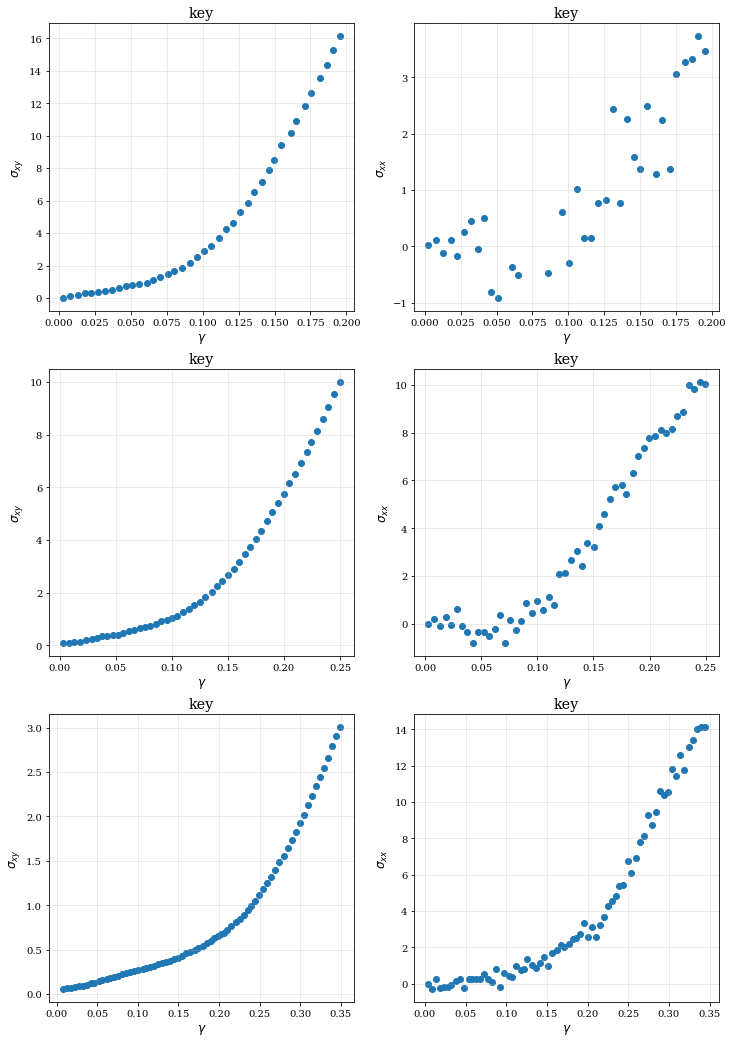

In [17]:
# Plot all graphs in data
fig, axs = plt.subplots(3, 2, figsize=(12, 18))
for i, key in enumerate(data.keys()):
    ax = axs[i//2, i%2]
    ax.scatter(data[key]['x'], data[key]['y'])
    ax.set_title(f'key')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('$\gamma$')
    ax.set_ylabel(f'$\sigma_{{{key[-2:]}}}$')

In [27]:
''' MATERIAL PROPERTIES '''


##### Penalty parameter (0) #####\n,
K = 1000.0
##### Isotropic matrix (1-3) #####
C10 = 0.0 # 0.0
C01 = 0.0 # 0.0
PHI = 1.0 # Filament volume fraction
###### Single Filament (4-11) #####
CACTIN = 9.5 # Actin concentration
R = 0.1 # CL relative concentration
R0C = 0.014 # CL initial end-to-end distance [microm] 0.014
ETA = 1. # CL stiffness [0,1] 0.6666
MU0 = 38600.0 # Stretch modulus [pN] inf
BETA = 0.438 # 0.5
B0 = 294.0*16.0*1.38065e-5 # Bending stiffness (T*Lp*kb) [pN * microm**2] 294.0*16.0*1.38e-5
LAMBDA0 = 1.000 # Pre-stretch 1.00
##### Affine Network (12-13) #####
A = 1.14 # L/r0f
B = 0.001 # Dispersion parameter 0.001

base_material_properties = [K,
    C10, C01, PHI,
    CACTIN, R, R0C, ETA, MU0, BETA, B0, LAMBDA0,
    A, B
]

mat_props_tex = ['$K$', '$C_{10}$', '$C_{01}$', '$\\phi$', 
                    '$C_{\\mathrm{actin}}$', '$R$', '$r_{0,c}$', '$\\eta$', '$\\mu_0$', '$\\beta$', '$B_0$', '$\\lambda_0$', 
                    '$a$', '$b$']

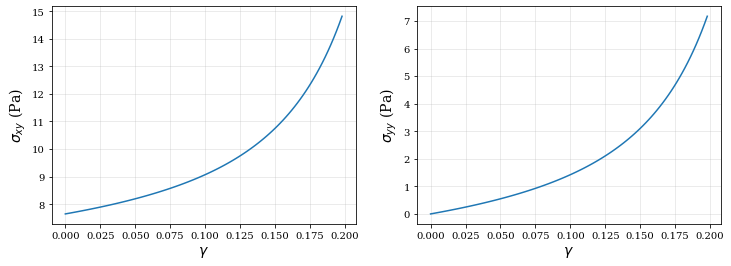

In [29]:
'SHEAR'

shear_list = [], []
material_properties = base_material_properties.copy()

shear_initial = 0.0
shear_max = 0.2
nsteps = 100
dshear = (shear_max-shear_initial)/nsteps

sxy, syy = np.zeros((1, nsteps)), np.zeros((1, nsteps))
shear_array = np.arange(shear_initial, shear_max, dshear)

time = [0, 0]
dtime=0.1
kstep=1
for i, stretch in enumerate(shear_array):
    F = dfgrd('SSx', stretch)
    stress_uni, _ = umatpy.run_umat_py(material_properties, F, time, dtime, kstep)
    sxy[0,i] = stress_uni[1] - stress_sh[2]
    time[0] += dtime
    kstep += 1

time = [0, 0]
kstep=1
for j, shear in enumerate(shear_array):
    F = dfgrd('SSx', shear)
    stress_sh, _ = umatpy.run_umat_py(material_properties, F, time, dtime, kstep)
    syy[0,j] = stress_sh[1]
    time[0] += dtime
    kstep += 1


fig, axs = plt.subplots(1,2, figsize = (12,4))
axs[0].plot(shear_array, sxy[0,:])
axs[0].set_xlabel('$\gamma$', fontsize=14)
axs[0].set_ylabel('$\\sigma_{xy}$ (Pa)', fontsize=14)
axs[0].grid(alpha=0.3)
axs[1].plot(shear_array, syy[0, :])
axs[1].set_xlabel('$\gamma$', fontsize=14)
axs[1].set_ylabel('$\\sigma_{yy}$ (Pa)', fontsize=14)
axs[1].grid(alpha=0.3)


(array([  1.58551534,   3.17103067,   9.51309202,  14.26963803,
         14.26963803,  15.85515336,  36.46685273,  33.29582206,
         60.24958278,  68.17715946,  80.86128215, 125.25571157,
        118.91365022, 137.93983426, 130.01225757, 145.86741094,
        112.57158888,  90.37437417, 112.57158888,  77.69025148,
         49.15097542,  44.39442942,  26.95376072,  26.95376072,
         22.19721471,  11.09860735,   6.34206135,   6.34206135,
          1.58551534,   1.58551534]),
 array([0.00484726, 0.00547797, 0.00610868, 0.00673939, 0.0073701 ,
        0.0080008 , 0.00863151, 0.00926222, 0.00989293, 0.01052364,
        0.01115435, 0.01178506, 0.01241577, 0.01304648, 0.01367719,
        0.0143079 , 0.01493861, 0.01556932, 0.01620003, 0.01683074,
        0.01746145, 0.01809216, 0.01872287, 0.01935358, 0.01998429,
        0.020615  , 0.02124571, 0.02187642, 0.02250713, 0.02313784,
        0.02376855]),
 <BarContainer object of 30 artists>)

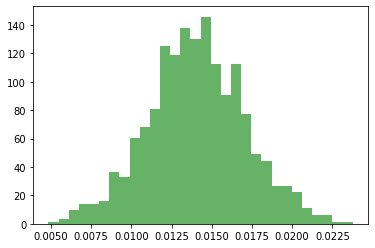

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Lognormal distribution with mean 30 and std 2.5
mu = 0.014
sigma = 0.003
s = np.random.normal(mu, sigma, 1000)
# Plot the histogram
plt.hist(s, bins=30, density=True, alpha=0.6, color='g')

In [8]:
np.sum(s > 0)

1000